# Objective
**[MUST]** Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard. We recommend the Kaggle Datasets below but you are free to choose any dataset that you feel comfortable with:
- [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)
- [IEEE-CIS Fraud Detection (“blind” data and difficult dataset)](https://www.kaggle.com/c/ieee-fraud-detection/overview)

You will need to export your trained models as .pkl file and upload it on github. Additionally add your Jupyter Notebook Link in the ReadMe.

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
# https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a
# Using the natural log, so ln / log base e
def rmsle(r_pred, r_true):
    return (np.log(r_pred+1) - np.log(r_true+1)).mean()**0.5
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [4]:
# Dataset
path = Path('../../Datasets/nyc-taxi-trip-duration')
path.ls()

(#3) [Path('../../Datasets/nyc-taxi-trip-duration/sample_submission.csv'),Path('../../Datasets/nyc-taxi-trip-duration/test.csv'),Path('../../Datasets/nyc-taxi-trip-duration/train.csv')]

I checked the `test.csv` to see how they divide the test data. It seems random. I checked the pickup_datetime and they're quite random.

In [5]:
df = pd.read_csv(path/'train.csv', low_memory=False)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,...,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,...,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,...,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,...,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,...,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,...,-73.972923,40.782520,N,435


In [6]:
df = add_datepart(df,'pickup_datetime', time=True)
df = add_datepart(df,'dropoff_datetime', time=True)
df.head()

,id,vendor_id,pickup_datetimeWeek,dropoff_datetimeWeek,...,dropoff_datetimeHour,dropoff_datetimeMinute,dropoff_datetimeSecond,dropoff_datetimeElapsed
0,id2875421,2,11,11,...,17,32,30,1457976750
1,id2377394,1,23,23,...,0,54,38,1465692878
2,id3858529,2,3,3,...,12,10,48,1453205448
3,id3504673,2,14,14,...,19,39,40,1459971580
4,id2181028,2,12,12,...,13,38,10,1458999490


In [7]:
dep_var = 'trip_duration'
df[dep_var] = df[dep_var].astype('float64')
df[dep_var] = np.log(df[dep_var])

In [8]:
df['pickup_datetimeElapsed'] = df['pickup_datetimeElapsed'].astype('uint64')
df['dropoff_datetimeElapsed'] = df['dropoff_datetimeElapsed'].astype('uint64')
df['passenger_count'] = df['passenger_count'].astype('uint64')

In [9]:
df = df_shrink(df)
df.dtypes

id                               category
vendor_id                            int8
pickup_datetimeWeek                UInt32
dropoff_datetimeWeek               UInt32
passenger_count                     uint8
                                   ...   
dropoff_datetimeIs_year_start        bool
dropoff_datetimeHour                 int8
dropoff_datetimeMinute               int8
dropoff_datetimeSecond               int8
dropoff_datetimeElapsed            uint32
Length: 41, dtype: object

In [10]:
procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))

In [11]:
cont = ['pickup_longitude', 'pickup_latitude', 
        'dropoff_longitude', 'dropoff_latitude',
        'passenger_count',
        'pickup_datetimeElapsed','dropoff_datetimeElapsed',
        'dropoff_datetimeHour','dropoff_datetimeMinute','dropoff_datetimeSecond',
        'pickup_datetimeHour','pickup_datetimeMinute','pickup_datetimeSecond',
       ]
cat = list(np.setdiff1d(np.array(df.columns),[*cont, 'trip_duration']))
cont,cat

(['pickup_longitude',
  'pickup_latitude',
  'dropoff_longitude',
  'dropoff_latitude',
  'passenger_count',
  'pickup_datetimeElapsed',
  'dropoff_datetimeElapsed',
  'dropoff_datetimeHour',
  'dropoff_datetimeMinute',
  'dropoff_datetimeSecond',
  'pickup_datetimeHour',
  'pickup_datetimeMinute',
  'pickup_datetimeSecond'],
 ['dropoff_datetimeDay',
  'dropoff_datetimeDayofweek',
  'dropoff_datetimeDayofyear',
  'dropoff_datetimeIs_month_end',
  'dropoff_datetimeIs_month_start',
  'dropoff_datetimeIs_quarter_end',
  'dropoff_datetimeIs_quarter_start',
  'dropoff_datetimeIs_year_end',
  'dropoff_datetimeIs_year_start',
  'dropoff_datetimeMonth',
  'dropoff_datetimeWeek',
  'dropoff_datetimeYear',
  'id',
  'pickup_datetimeDay',
  'pickup_datetimeDayofweek',
  'pickup_datetimeDayofyear',
  'pickup_datetimeIs_month_end',
  'pickup_datetimeIs_month_start',
  'pickup_datetimeIs_quarter_end',
  'pickup_datetimeIs_quarter_start',
  'pickup_datetimeIs_year_end',
  'pickup_datetimeIs_year_star

In [12]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [13]:
current_path = Path('.')
current_path

Path('.')

In [14]:
save_pickle(current_path/'models/tabularPandaTo.pkl',to)

In [16]:
to = load_pickle(current_path/'models/tabularPandaTo.pkl')

In [15]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [16]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [17]:
m = rf(xs, y, n_estimators=40, max_samples=200_000);

In [18]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.387455, 0.421051)

In [19]:
r_mse(m.oob_prediction_, y)

0.420005

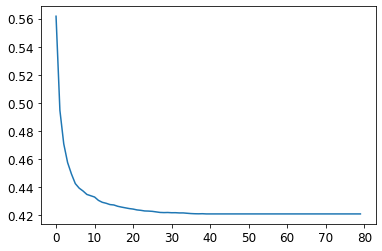

In [20]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(80)]);

# Remove some irrelevant columns

In [21]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [22]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
27,pickup_longitude,0.208096
28,pickup_latitude,0.207801
29,dropoff_longitude,0.188974
30,dropoff_latitude,0.185264
37,pickup_datetimeHour,0.027462
35,dropoff_datetimeMinute,0.025807
38,pickup_datetimeMinute,0.025642
34,dropoff_datetimeHour,0.022400
12,id,0.013294
1,dropoff_datetimeDayofweek,0.012089


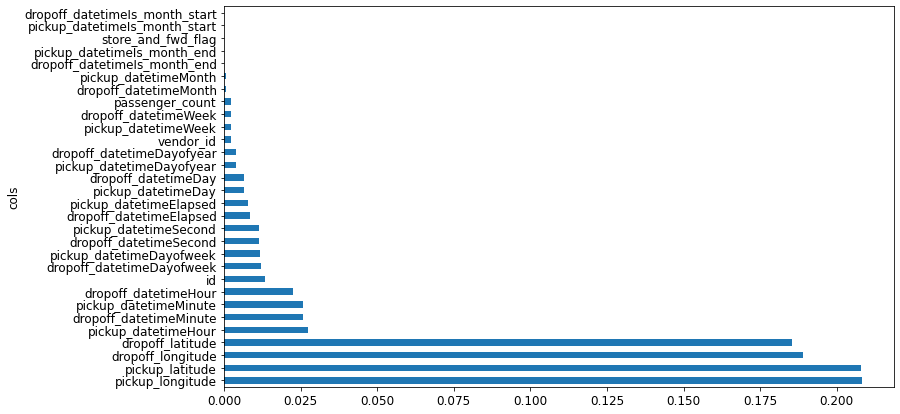

In [23]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [26]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

17

In [27]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [28]:
m = rf(xs_imp, y)

In [29]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.387381, 0.420332)

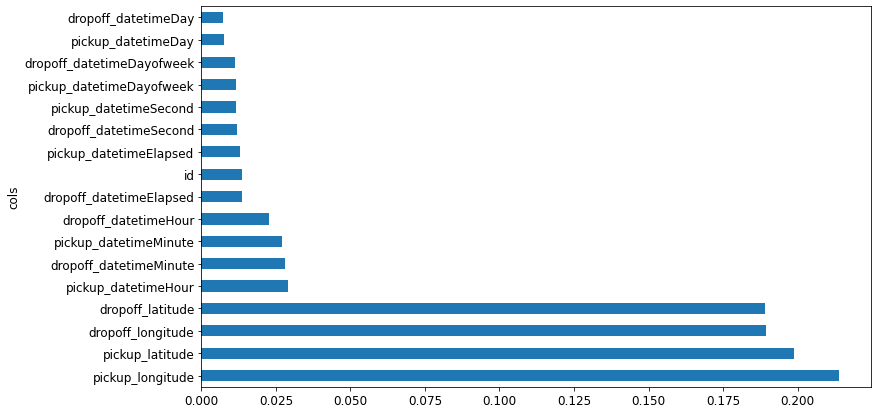

In [30]:
plot_fi(rf_feat_importance(m, xs_imp));

In [40]:
to_drop = ['id',
           'pickup_datetimeDay','dropoff_datetimeDay',
           'pickup_datetimeSecond','dropoff_datetimeSecond'
          ]

In [46]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [47]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.38111, 0.411589)

# Neural Network

In [50]:
df_nn_final = df[list(xs_final.columns) + [dep_var]]

In [63]:
cont_nn = list(np.intersect1d(cont, list(xs_final.columns)))
cat_nn = list(np.intersect1d(cat, list(xs_final.columns)))
cont_nn, cat_nn

(['dropoff_datetimeElapsed',
  'dropoff_datetimeHour',
  'dropoff_datetimeMinute',
  'dropoff_latitude',
  'dropoff_longitude',
  'pickup_datetimeElapsed',
  'pickup_datetimeHour',
  'pickup_datetimeMinute',
  'pickup_latitude',
  'pickup_longitude'],
 ['dropoff_datetimeDayofweek', 'pickup_datetimeDayofweek'])

In [64]:
df_nn_final[cat_nn].nunique()

dropoff_datetimeDayofweek    7
pickup_datetimeDayofweek     7
dtype: int64

In [78]:
procs_nn = [Categorify, FillMissing]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [79]:
dls = to_nn.dataloaders(1024)

In [80]:
y = to_nn.train.y
y.min(),y.max()

(0.0, 15.075754165649414)

In [81]:
learn = tabular_learner(dls, y_range=(0,16), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss, metrics=r_mse)

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.25118863582611084)

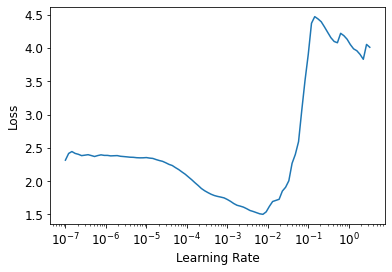

In [70]:
learn.lr_find()

In [82]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,r_mse,time
0,0.093178,0.091643,0.301554,00:13
1,0.056004,0.043325,0.206105,00:13
2,0.041808,0.032045,0.176499,00:14
3,0.029789,0.024894,0.154618,00:14
4,0.025747,0.020252,0.139038,00:14


In [83]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.142309

In [87]:
learn.export(fname='models/TaxiTripNN.pkl')

# Ensemble

In [84]:
rf_preds = m.predict(valid_xs_final)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [85]:
r_mse(ens_preds,valid_y)

0.241185

## Benchmark Leaderboard (Root Mean Squared Logarithmic Error)

### Private
- 1. 0.28976
- 10. 0.31157
- 50. 0.36730
		
### Public
- 1. 0.28882
- 10. 0.30995
- 50. 0.37050

# Conclusion

Neural Network / Deep Layer gives the best prediction, even better than ensemble with random forest.

If everything I've done was correct, Neural Network could easily surpass the 1st rank on kaggle.